In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry

from pprint import pprint
from datetime import datetime
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 6)

# Read data

In [75]:
df = pd.read_csv('../data/DEvideos.csv')

## Parse tags and convert

Breaks the tag-strings into single elements and formats them. The following formatting is applied:
* Remove enclosing quotation marks ("")
* convert to lower case
* remove all duplicates (due to conversion to lower)

After formatting, the tags are filter by the following rules. The tag will be excluded when:
* The tag matches the '[none]' tag
* The tag is a number (to remove time related data)
* The tag describes a country
* The tag describes a language (resource intensive due to large amount of languages)

In [76]:
filter_countries = True
countries = [s.name for s in pycountry.countries]
filter_languages = False # Resource intensive, use with care
languages = [s.name for s in pycountry.languages]

def isValidTag(s):
    return s != '[none]' \
    and not s.isnumeric() \
    and not(filter_countries and s in countries) \
    and not (filter_languages and s in languages)
def formatData(s):
    s2 = map(lambda x: x.strip('\"').lower(), s)
    res = []
    [res.append(x) for x in s2 if x not in res]
    return res

df['parsed_tags'] = df['tags'].str.split('|')\
    .apply(formatData)\
    .apply(lambda x: list(filter(isValidTag, x)))
df['parsed_tags'].head()



0    [inscope21, sing zu ende, gesangseinlagen, ges...
1    [kinder, ferngesteuert, kinder ferngesteuert, ...
2    [last week tonight trump presidency, last week...
3    [physik, wissenschaft, technik, science-fictio...
4    [kelly, missesvlog, kelly song, bausa, bausa w...
Name: parsed_tags, dtype: object

## Calculate tag counts

In [77]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])
tag_counts = to_1D(df['parsed_tags']).value_counts()

## Display top 20 tags

d:\programme\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

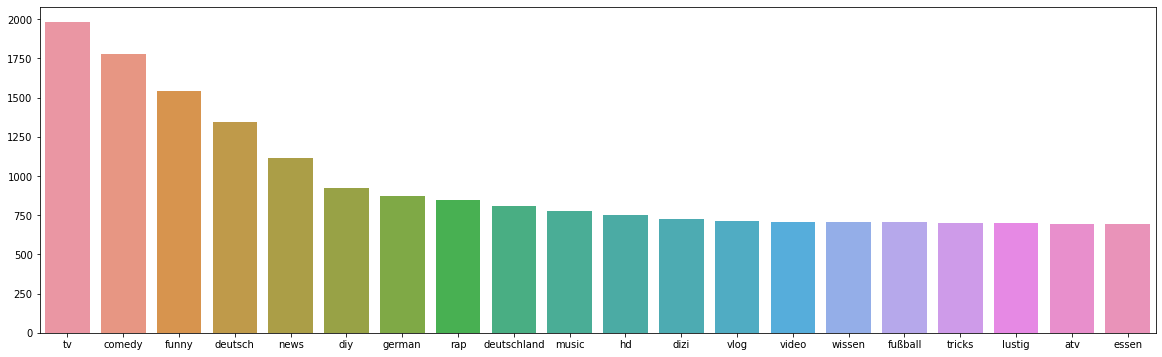

In [78]:
top_tags = tag_counts.head(20)
sns.barplot(top_tags.index, top_tags.values)

# https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173

## Convert tags into their own table

In [79]:
tags_df = df['parsed_tags'].apply(pd.Series)
tags_df.head()

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
0,inscope21,sing zu ende,gesangseinlagen,gesang,gesungen,songs nachsingen,nachsingen,songs covern,carpool karaoke,witziger gesang,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,kinder,ferngesteuert,kinder ferngesteuert,luke mockridge kinder,luke die woche und ich kinder,prank,verarschen,kiosk,funkgerät,falschgeld,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,last week tonight trump presidency,last week tonight donald trump,john oliver trump,donald trump,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,physik,wissenschaft,technik,science-fiction,außerirdische,alien,aliens,fermi,fermi-paradoxon,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,kelly,missesvlog,kelly song,bausa,bausa was du liebe nennst,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Calculate tag usage

In [80]:
tags_df.iloc[:, 0].value_counts(normalize=True)

atv                         0.009257
çukur                       0.006242
fox                         0.005501
fußball                     0.004787
шарий                       0.004734
                              ...   
exo-cbx                     0.000026
liverpool fc                0.000026
شاه                         0.000026
garden (say it like dat)    0.000026
bts woojihwa                0.000026
Name: 0, Length: 9978, dtype: float64

## Convert tags to binary table

In [81]:
def boolean_df(item_lists, items):
    bool_dict={}
    for i, item in enumerate(items):
        bool_dict[item] = item_lists.apply(lambda x: item in x)
    return pd.DataFrame(bool_dict)

#unique_items = tag_counts.where(lambda x: x > 500).dropna().index
unique_items = tag_counts.head(20).tail(20).index
head_tags = df['parsed_tags']
tags_bool = boolean_df(head_tags, unique_items)
tags_bool.head()

,tv,comedy,funny,deutsch,news,diy,german,rap,deutschland,music,hd,dizi,vlog,video,wissen,fußball,tricks,lustig,atv,essen
0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


## Tags as correlation matrix

<AxesSubplot:>

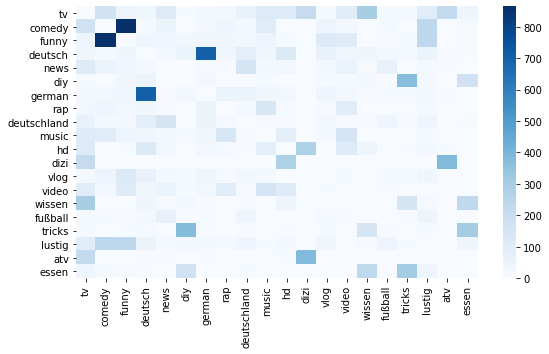

In [82]:
tags_int = tags_bool.astype(int)
tags_freq_mat = np.dot(tags_int.T, tags_int)
np.fill_diagonal(tags_freq_mat, 0)

tags_freq = pd.DataFrame(tags_freq_mat, columns = unique_items, index = unique_items)

fix, ax = plt.subplots(figsize = (9,5))
sns.heatmap(tags_freq, cmap = "Blues")
#plt.xticks(rotation=50)
#plt.savefig("heatmap.png", dpi = 300)